In [2]:
import os
import numpy as np
import pandas as pd
import json
import lightgbm as lgb
from collections import Counter
import matplotlib.pyplot as plt
from scipy import interp
import copy
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score as bacc
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold

In [52]:
graphnames = ['Cora', 'Citeseer', 'Pubmed', 'HomoSapiens', 'Wikipedia', 'BlogCatalog']
idx = 0
graphname = graphnames[idx]
multilabel=False
if idx > 2:
    multilabel=True
emb_size = 50
hop = 2
data_dir = os.path.expanduser("../Graphs/"+graphname)
print(data_dir)

../Graphs/Cora


In [53]:
rwalk_path = data_dir + "/vectors/vectors_rwalk_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(rwalk_path, "r") as read_file:
    rwalk_vectors = json.load(read_file)

In [54]:
nodesketch_path = data_dir + "/vectors/vectors_nodesketch_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(nodesketch_path, "r") as read_file:
    ns_vectors = json.load(read_file)

In [55]:
minwise_path = data_dir + "/vectors/vectors_minwise_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(minwise_path, "r") as read_file:
    minwise_vectors = json.load(read_file)

In [56]:
l1_path = data_dir + "/vectors/vectors_l1_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l1_path, "r") as read_file:
    l1_vectors = json.load(read_file)

In [57]:
l2_path = data_dir + "/vectors/vectors_l2_all_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l2_path, "r") as read_file:
    l2_vectors = json.load(read_file)

In [58]:
x = 2
paths = ['graph_nodes.txt', 'labels.txt', 'words_indices.txt']
features_path = data_dir + "/data/" + paths[x] 
features = []
with open(features_path, "r") as features_file:
    for f in features_file:
        features.append(f.strip())
features.append("")
features.append(" ")
features.append("nan")

In [59]:
nodes_with_labels = pd.read_csv(data_dir + '/data/nodes_with_labels.csv')

In [60]:
def get_labels(nodes_with_labels):
    all_labels = set() 
    for idx, row in nodes_with_labels.iterrows():
        node = row['node']
        row_labels = [row['label']]
        row_labels = row["label"].split("=")
        row_labels = row_labels[1:-1]   
        if len(row_labels) == 0:
            continue
        for rl in row_labels:
            all_labels.add(rl)
    all_labels.add('none')
    all_labels.add('nan')
    return list(all_labels)

In [61]:
#features = get_labels(nodes_with_labels)

In [62]:
features[:3]

['w-615', 'w-121', 'w-508']

In [63]:
def get_train_test(vectors, nodes_with_labels, x):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    labels = {}
    
    for idx, row in nodes_with_labels.iterrows():
        node = row['node']
        row_labels = [row['label']]
        vals = vectors[str(node)]
        features = {}
        for i, v in enumerate(vals):
            features["f"+str(i)] = v[x] 
        if row['label'][:4] == 'None':
            X_test.append(features)
        else:
            X_train.append(features)
        # if multilabel:
        row_labels = row["label"].split("=")
        row_labels = row_labels[1:-1]   
        if len(row_labels) == 0:
            continue
        for rl in row_labels:
            if rl not in labels:
                labels[rl] = len(labels)
        enc_label = []
        for rl in row_labels:
            enc_label.append(labels[rl])
        if row['label'][:4] == 'None':    
            y_test.append(enc_label)
        else:
            y_train.append(enc_label)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    return X_train, X_test, y_train, y_test

In [64]:
# generate a dataset with labels from the trained embeddings
def get_X_y(vectors, nodes_with_labels, x, multilabel=False):
    
    
    
    X = []
    y = []
    labels = {}
    
    for idx, row in nodes_with_labels.iterrows():
        node = row['node']
        row_labels = [row['label']]
        vals = vectors[str(node)]
        features = {}
        for i, v in enumerate(vals):
            features["f"+str(i)] = v[x] 
        X.append(features)
        if multilabel:
            row_labels = row["label"].split("=")
            row_labels = row_labels[1:-1]   
        if len(row_labels) == 0:
            continue
        for rl in row_labels:
            if rl not in labels:
                labels[rl] = len(labels)
        enc_label = []
        for rl in row_labels:
            enc_label.append(labels[rl])
        y.append(enc_label)
    X = pd.DataFrame(X)
    return X, y

In [65]:
X_rw, y_rw = get_X_y(rwalk_vectors, nodes_with_labels, x=x, multilabel=multilabel)

In [66]:
X_ns, y_ns = get_X_y(ns_vectors, nodes_with_labels, x=x, multilabel=multilabel)

In [67]:
X_mw, y_mw = get_X_y(minwise_vectors, nodes_with_labels, x=x, multilabel=multilabel)

In [68]:
X_l1, y_l1 = get_X_y(l1_vectors, nodes_with_labels, x=x, multilabel=multilabel)

In [69]:
X_l2, y_l2 = get_X_y(l2_vectors, nodes_with_labels, x=x, multilabel=multilabel)

In [70]:
# just a check if everything seems ok
# len(set(X_rw["f20"])), len(set(X_ns["f20"])), len(set(X_mw["f20"])), \
# len(set(X_l1["f20"])), len(set(X_l2["f20"]))

In [71]:
# for i in range(50):
#      print(len(set(X_rw["f"+str(i)])), len(set(X_ns["f"+str(i)])), len(set(X_mw["f"+str(i)])), \
#        len(set(X_l1["f"+str(i)])), len(set(X_l2["f"+str(i)]))) 

In [72]:
# just for double schecking
def my_prec_recall(y_true, y_pred):
    tp = 0
    fp = 0
    fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        if yt == 1 and yp == 0:
            fn += 1
        if yt == 0 and yp == 1:
            fp += 1
    return tp/(tp+fp), tp/(tp+fn)
        

In [73]:
def plot_label_distribution(y):
    counts = {}
    for labels_i in y:
        for l_i in labels_i:
            counts.setdefault(l_i, 0)
            counts[l_i] += 1
    
    top_counts = sorted([(cnt, lbl) for lbl, cnt in counts.items()], reverse=True)
    plt.bar([i for i in range(len(top_counts))], [c for c, _ in top_counts], alpha=0.7)

In [74]:
def one_hot(y, top=10):
    
    counts = {}
    for labels_i in y:
        for l_i in labels_i:
            counts.setdefault(l_i, 0)
            counts[l_i] += 1
    
    top_counts = sorted([(cnt, lbl) for lbl, cnt in counts.items()], reverse=True)[:top]
    labels = {cnt_lbl[1]: i for i,cnt_lbl in enumerate(top_counts)}
        
    top = min(top, len(counts)-1)
    
    encoded = np.zeros((len(y), top+1))
    for i, labels_i in enumerate(y):
        for l_i in labels_i:
            if l_i in labels:
                encoded[i, labels[l_i]] = 1
            else:
                encoded[i, top] = 1
            
    return encoded

In [75]:
len(features)

1435

In [76]:
def multilabel_classification(X, y, features, top_classes, res_path):
    
    y = one_hot(y, top_classes) 

    label_encoder = LabelEncoder()
    label_encoder.fit(features)
    
    X = copy.deepcopy(X)
    for c in X.columns: 
        X.loc[:, c] = label_encoder.transform([str(x) for x in X[c]])
        
    
    # X.to_csv("/home/koki2/Desktop/X.csv", index=False)
    f1_micros = []
    f1_macros = []
    nr_iters = 10
    
    for i in range(nr_iters):    
        print('Iter', i)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
        
        model = tree.DecisionTreeClassifier() 
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

        # n_classes = y_test.shape[1]
        y_pred = model.predict_proba(X_test)
        y_pred_abs = model.predict(X_test)
        
        f1_micro = f1_score(y_test, y_pred_abs, average='micro')
        f1_macro = f1_score(y_test, y_pred_abs, average='macro')
        
        print("F1", f1_micro, f1_macro)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)
        
    print('Micro F1', np.mean(f1_micros))
    print('Macro F1', np.mean(f1_macros))
    
    with open(res_path + "_emb_micro_F1.txt", "w") as f:
        f.write(str(np.mean(f1_micros)) + " " + str(np.std(f1_micros)))
        
    with open(res_path + "_emb_macro_F1.txt", "w") as f:
        f.write(str(np.mean(f1_macros)) + " " + str(np.std(f1_macros)))
    

In [77]:
# def multilabel_classification(X_train, X_test, y_train, y_test, features, top_classes, res_path):
#     # mlb = MultiLabelBinarizer()
#     y = y_train + y_test
#     y = one_hot(y, top_classes) # mlb.fit_transform(y)
#     y_train = y[:len(y_train)]
#     y_test = y[len(y_train):]
    
# #     lgb_params = {'objective':'binary',
# #                   'metric': 'auc',
# #             'boosting_type':'gbdt',
# #             'n_jobs':4,
# #             'max_depth':-1,
# #              # 'num_class': len(labels),
# #             'learning_rate':0.1,
# #             'tree_learner':'serial',
# #             'n_estimators':2000,
# #             'verbose':-1,
# #             'seed': 73,
# #             'feature_fraction':1}
    
#     label_encoder = LabelEncoder()
#     label_encoder.fit(features)
    
#     X_train = copy.deepcopy(X_train)
#     for c in X_train.columns: 
#         X_train.loc[:, c] = label_encoder.transform([str(x) for x in X_train[c]])
        
#     X_test = copy.deepcopy(X_test)
#     for c in X_test.columns: 
#         X_test.loc[:, c] = label_encoder.transform([str(x) for x in X_test[c]])
    
#     # X.to_csv("/home/koki2/Desktop/X.csv", index=False)
#     f1_micros = []
#     f1_macros = []
#     nr_iters = 10
#     #for train_index, test_index in kf.split(X):
#     for i in range(nr_iters):    
#         print('Iter', i)
#         X_tr, _, y_tr, _ = train_test_split(X_train, y_train, train_size=0.9)
#         # X_train, X_test = X[train_index], X[test_index]
#         # y_train, y_test = y[train_index], y[test_index]
#         # model = lgb.LGBMClassifier( **lgb_params) 
        
#         # model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
#         model = tree.DecisionTreeClassifier() 
#         model = OneVsRestClassifier(model)
#         model.fit(X_tr, y_tr)

#         # n_classes = y_test.shape[1]
#         y_pred = model.predict_proba(X_test)
#         y_pred_abs = model.predict(X_test)
        
#         f1_micro = f1_score(y_test, y_pred_abs, average='micro')
#         f1_macro = f1_score(y_test, y_pred_abs, average='macro')
#         #bf1 = f1_score(y_test.ravel(), y_pred_abs.ravel(), average='binary')
#         print("F1", f1_micro, f1_macro)
#         f1_micros.append(f1_micro)
#         f1_macros.append(f1_macro)
        
#     print('Micro F1', np.mean(f1_micros))
#     print('Macro F1', np.mean(f1_macros))
# #     print('Macro AUC', np.mean(macros))
# #     print('Accuracy', np.mean(accs))
    
#     with open(res_path + "_emb_micro_F1.txt", "w") as f:
#         f.write(str(np.mean(f1_micros)) + " " + str(np.std(f1_micros)))
        
#     with open(res_path + "_emb_macro_F1.txt", "w") as f:
#         f.write(str(np.mean(f1_macros)) + " " + str(np.std(f1_macros)))
    

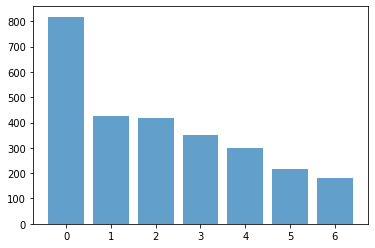

In [78]:
plot_label_distribution(y_l1)

In [79]:
top_classes=30

In [80]:
res_path = data_dir + "/results/rwalk_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification(X_rw, y_rw, features, top_classes, res_path)

Iter 0
F1 0.43538594969644406 0.4146292473163835
Iter 1
F1 0.39329805996472667 0.3614777957510787
Iter 2
F1 0.3769911504424779 0.3382094444764236
Iter 3
F1 0.3739279588336192 0.354460285549025
Iter 4
F1 0.37589928057553956 0.35708115957738834
Iter 5
F1 0.35325602140945583 0.3216848618979103
Iter 6
F1 0.37213403880070545 0.34777385269269157
Iter 7
F1 0.3899821109123434 0.3600233434347147
Iter 8
F1 0.36465116279069765 0.3326046506391326
Iter 9
F1 0.3874439461883408 0.367405843833095
Micro F1 0.3822969679614351
Macro F1 0.35553504851678436


In [81]:
res_path = data_dir + "/results/nodesketch_" + str(emb_size) + "_hop_" + str(hop)
multilabel_classification_alt(X_ns, y_ns, features, top_classes, res_path)
# multilabel_classification(X_ns_train, X_ns_test, y_ns_train, y_ns_test, features, top_classes, res_path)

Iter 0
F1 0.6696750902527077 0.6483240076836135
Iter 1
F1 0.6731793960923623 0.6535405390280546
Iter 2
F1 0.6737777777777777 0.6600630016312845
Iter 3
F1 0.6516651665166516 0.6341134083668016
Iter 4
F1 0.6384129846708746 0.6291831549698107
Iter 5
F1 0.6877912395153776 0.6726733913798606
Iter 6
F1 0.6648599819331527 0.6383200608363772
Iter 7
F1 0.672678088367899 0.6557443861466133
Iter 8
F1 0.6777163904235728 0.6702677293078327
Iter 9
F1 0.6666666666666666 0.6526777789909621
Micro F1 0.6676422782217043
Macro F1 0.6514907458341211


In [82]:
res_path = data_dir + "/results/minwise_" + str(emb_size) + "_hop_" + str(hop)
multilabel_classification_alt(X_mw, y_mw, features, top_classes, res_path)
#multilabel_classification(X_mw_train, X_mw_test, y_mw_train, y_mw_test, features, top_classes, res_path)

Iter 0
F1 0.689908256880734 0.6708047366162587
Iter 1
F1 0.6846361185983828 0.6754328176491141
Iter 2
F1 0.6992619926199262 0.6891687607483818
Iter 3
F1 0.6866485013623979 0.6691722937412424
Iter 4
F1 0.7116788321167884 0.6940135661762031
Iter 5
F1 0.6876737720111215 0.6700808440014464
Iter 6
F1 0.6916588566073102 0.681524759071179
Iter 7
F1 0.6708746618575293 0.6541080983096691
Iter 8
F1 0.6751592356687899 0.6570939101636196
Iter 9
F1 0.6828828828828829 0.6636236049926778
Micro F1 0.6880383110605862
Macro F1 0.6725023391469792


In [83]:
res_path = data_dir + "/results/l1_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification_alt(X_l1, y_l1, features, top_classes, res_path)
# multilabel_classification(X_l1_train, X_l1_test, y_l1_train, y_l1_test, features, top_classes, res_path)

Iter 0
F1 0.6672845227062094 0.6677240786147303
Iter 1
F1 0.674567000911577 0.6523314953732796
Iter 2
F1 0.6562786434463794 0.6534926160828084
Iter 3
F1 0.6690647482014389 0.6488636550749423
Iter 4
F1 0.6555863342566943 0.6489701674781463
Iter 5
F1 0.6953339432753889 0.7014845725761277
Iter 6
F1 0.6587155963302752 0.6328337856943537
Iter 7
F1 0.6504504504504504 0.6202695214812886
Iter 8
F1 0.6208144796380091 0.6148891835324451
Iter 9
F1 0.6636528028933093 0.6466216079281762
Micro F1 0.661174852210973
Macro F1 0.6487480683836298


In [84]:
res_path = data_dir + "/results/l2_" + str(emb_size) + "_hop_" + str(hop) 
multilabel_classification_alt(X_l2, y_l2, features, top_classes, res_path)
# multilabel_classification(X_l2_train, X_l2_test, y_l2_train, y_l2_test, features, top_classes, res_path)

Iter 0
F1 0.625 0.6221843958635253
Iter 1
F1 0.6300884955752213 0.6341864995465702
Iter 2
F1 0.6347517730496454 0.6241787695212556
Iter 3
F1 0.6246624662466247 0.606751548535412
Iter 4
F1 0.6132339235787512 0.6117566096327005
Iter 5
F1 0.6594202898550725 0.6289318942333858
Iter 6
F1 0.6350093109869646 0.6145288629818292
Iter 7
F1 0.652094717668488 0.6441132001562634
Iter 8
F1 0.6186518928901201 0.6058359062190174
Iter 9
F1 0.6194852941176472 0.6024545613721061
Micro F1 0.6312398163968534
Macro F1 0.6194922248062065


# Interpretability

In [85]:
def get_distr(X, y, labels, index):
    
    for label in labels:
        X_label = X.iloc[[i for i, y_i in enumerate(y) if y_i[0]==label], :]
        # X_neg = X.iloc[[i for i, y_i in enumerate(y) if y_i==0], :]
        print(X_label.shape)

        dict_label = Counter(X_label.iloc[:, index])
        # dict_neg = Counter(X_neg.iloc[:, idx])

        top_pos = sorted([(cnt/X_label.shape[0], k) for k, cnt in dict_label.items()], reverse=True)[:10]
        plt.bar([i for i in range(len(top_pos))], [c for c, _ in top_pos], alpha=0.7)
        plt.xticks(np.arange(len(top_pos)), [n for cnt, n in top_pos], rotation=90, size=12)
        # plt.yscale('log')
        plt.ylim([0,0.7])
        plt.tight_layout()
        plt.savefig("/home/koki2/Dropbox/Research/DAMI/figures/pubmed_class_distr_" + \
                    str(int(label)) + ".png")
        plt.show()
    

(818, 50)


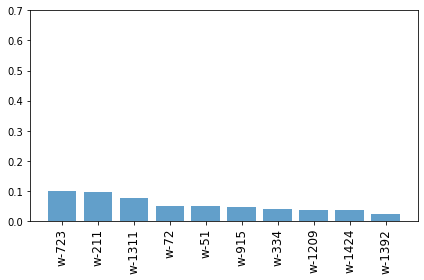

(180, 50)


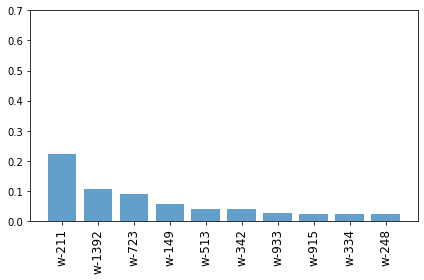

(217, 50)


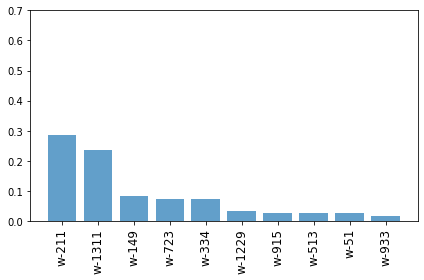

In [86]:
get_distr(X_l2, y_l2, labels=[0,1,2], index=9)